In [1]:
import line_profiler
import pandas as pd
import uproot
#import uproot3
import numpy as np
# import track_time_calibration as ttc
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
from tqdm import tqdm
sys.path.insert(1, '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/tracking/')
sys.path.insert(1, '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/utils/')
from track import Track
from track3D import Track3D
from hit import Hit
from data_loading import *


In [2]:
file_path = '/Users/lucahartman/Documents/EPFL/MA1/project/10h/data_0000.root' ## later, one can use concatenation of data_0001.root - data_0008.root files as well. One is enough for testing

df_hits = load_dataset(file_path)
og_len = len(df_hits)
df_hits.query('n_hits > 6', inplace=True)
df_hits.query('n_hits < 50', inplace=True)
new_len = len(df_hits)
print('selected {:.2f}% of all events'.format(new_len/og_len * 100))

selected 4.57% of all events


In [3]:
## This function provide the parameters x0 (or y0 depending on which hits we provide) and tx the angle of the trac
def create_tracks(df, plot = False, sampling = 10, angle_sampling = 240):
    tracks = []
    nb_events = len(df['n_hits'])
    steps = 9
    buff_start = None
    buff_evt_idx = None
    chi_squares = []
    for index, row in tqdm(df.iterrows(), total = df.shape[0], leave = False, desc = 'events'):
        channels = row['tofpet_channel']
        tofpet_id = row['tofpet_id']
        hits = [Hit(row,i) for i in range(row['n_hits'])]
        hitsX = [h for h in hits if h.is_sidex]
        hitsY = [h for h in hits if not h.is_sidex]
        
        ## Some events don't have three hits on one of the two sides and are thus not considered
        if len(hitsX) > 3 and len(hitsY) > 3:
            # get track parameters
            track = Track3D(hits)
            tracks.append(track)
            
        if track.reduced_chi2() is not None:
            chi_squares.append(track.reduced_chi2())

    return tracks, chi_squares
    

In [4]:
# getting tracks
tracks, chi_squares = create_tracks(df_hits.head(1000))
total_events = len(tracks)

In [288]:
samplings = np.linspace(1, 50, 20)
ratios_good_tracks = []
for s in tqdm(samplings, desc = 'sampling'):
    for t in tracks:
        t.find_track(int(s), 100)
    ratios_good_tracks.append(len([t for t in tracks if t.is_good_2D_fit()]) / total_events)
    
samplings2 = np.linspace(1, 50, 20)
ratios_good_tracks2 = []
for s in tqdm(samplings2, desc='sampling2'):
    for t in tracks:
        t.find_track(int(s), 200)
    ratios_good_tracks2.append(len([t for t in tracks if t.is_good_2D_fit()]) / total_events)
    
samplings3 = np.linspace(50, 250, 40)
ratios_good_tracks3 = []
for s in tqdm(samplings3, desc='sampling3'):
    for t in tracks:
        t.find_track(10, int(s))
    ratios_good_tracks3.append(len([t for t in tracks if t.is_good_2D_fit()]) / total_events)

samplings4 = np.linspace(50, 250, 40)
ratios_good_tracks4 = []
for s in tqdm(samplings4, desc='sampling3'):
    for t in tracks:
        t.find_track(20, int(s))
    ratios_good_tracks4.append(len([t for t in tracks if t.is_good_2D_fit()]) / total_events)
                

sampling3: 100%|██████████| 40/40 [03:24<00:00,  5.10s/it]


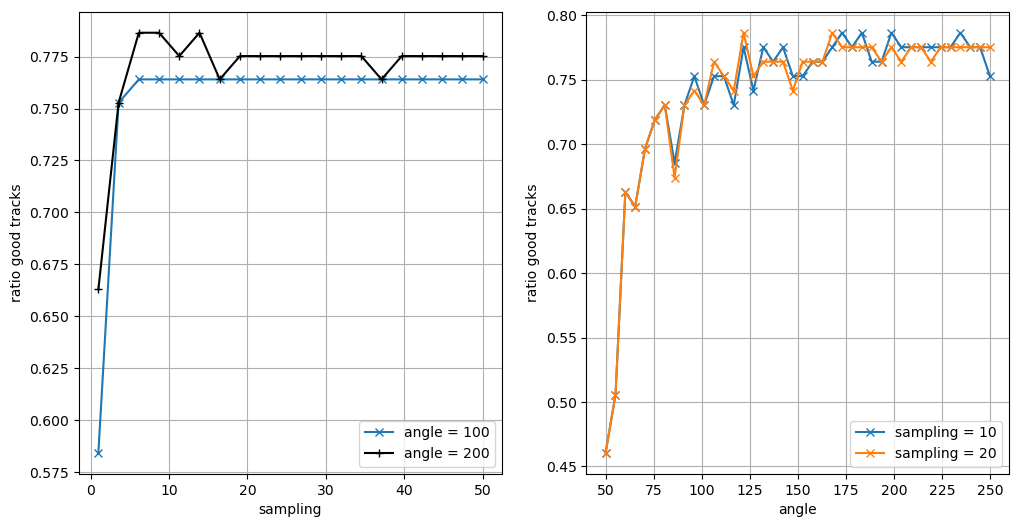

In [289]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 6)
axs[0].plot(samplings, ratios_good_tracks, 'x-', label = 'angle = 100')
axs[0].plot(samplings2, ratios_good_tracks2, 'k+-', label = 'angle = 200')
axs[1].plot(samplings3, ratios_good_tracks3, 'x-', label = 'sampling = 10')
axs[1].plot(samplings4, ratios_good_tracks4, 'x-', label='sampling = 20')

axs[0].set(xlabel='sampling', ylabel='ratio good tracks')
axs[0].grid(True)
axs[0].legend()
axs[1].set(xlabel='angle', ylabel='ratio good tracks')
axs[1].grid(True)
axs[1].legend()


In [ ]:
# getting the reduced chi^2 distribution
#chi_squares = [track.reduced_chi2() for track in tracks if track.reduced_chi2() is not None]

# import scipy.optimize as opt 
# import scipy.special as sp
# from scipy.stats import moyal

# chi_dist, edges = np.histogram(chi_squares, bins = 100, range = [0, 50])
# scaling = np.sum(chi_dist)
# chi_dist_scaled = chi_dist / scaling
# shift = (edges[2] - edges[1])/2
# x = [edges[i] + shift for i in range(len(edges)-1)]

# def fitfun(x, params):
    # mu, sigma, lambdaa = params
    # coeff = 2*mu + lambdaa * sigma**2 - 2.*np.array(x)
    # return 0.5 * lambdaa * np.exp(0.5 * lambdaa * coeff) * sp.erfc((mu + lambdaa * sigma**2 - x)/(np.sqrt(2)*sigma))
    # return np.exp(np.power(x - mu, 2)/(4*sigma**2)) / (np.sqrt(2*np.pi) * sigma)

# def dist_fit_diff(params, x = x, chi_dist = chi_dist_scaled):
    # return np.log(np.sum((chi_dist - fitfun(x, params))**2/chi_dist))

# x0 = [0, 2, 0.1]
# result = opt.minimize(dist_fit_diff, x0)
# print(result.x)

# params = moyal.fit(chi_dist_scaled)
# print(params)

In [ ]:
# plt.figure()
# plt.title('reduced chi square, {} events'.format(len(chi_squares)))
# plt.stairs(chi_dist, edges, fill=True, label='data')
# plt.axvline(x=2 * 3.841, ymin=0.0, ymax=1.0, color='g', label = 'limit')
# xs = np.linspace(0, 50, 1000)
# plt.plot(xs, scaling * fitfun(xs, result.x), 'r--', label='fit ({:.3f}, {:.3f}, {:.3f})'.format(result.x[0], result.x[1], result.x[2]))
# plt.plot(xs, scaling * moyal.pdf(xs), 'k--', label='moyal ({:.3f}, {:.3f})'.format(params[0], params[1]))
# plt.xlabel('$\chi^2_{\mathrm{red}}$')
# plt.ylabel('counts')
# plt.legend()



In [6]:
# timing difference between Hough, Hough precise and Kalman filter
from timeit import default_timer as timer
start = timer()
for t in tracks:
    t.find_track()
end = timer()
print('Hough {:.2f}'.format((end - start)/total_events))

start = timer()
for t in tracks:
    t.precise_track()
end = timer()
print('Hough precise {:.2f}'.format((end - start)/total_events))

start = timer()
for t in tracks:
    t.kalman_filter()
end = timer()
print('Kalman filter {:.2f}'.format((end - start)/total_events))


Hough 0.02
Hough precise 0.36
Kalman filter 0.01
